# Exercício 4: Análise de Entropia e Ganho de Informação

Este notebook implementa a análise de entropia e ganho de informação conforme especificado no guião, seguindo todos os requisitos:
- Cálculo de entropia sem bibliotecas de algoritmos de AA
- Análise com foco na classe Iris-setosa como alvo
- Particionamento por features discretizadas
- Explicação da construção de árvores de decisão

## Fundamentos Teóricos

### Entropia
A entropia mede a "impureza" ou "desordem" de um conjunto de dados:

**entropy(S) = -p₊ × log₂(p₊) - p₋ × log₂(p₋)**

Onde:
- p₊ = proporção de exemplos positivos
- p₋ = proporção de exemplos negativos

### Ganho de Informação
O ganho de informação mede quanto uma feature reduz a entropia:

**gain(S, a) = entropy(S) - (Σ(|Sᵥ| × entropy(Sᵥ)) / |S|)**

Onde:
- |S| = número total de elementos no conjunto S
- Sᵥ = subconjuntos criados pelos valores v da feature a
- |Sᵥ| = número de elementos em cada subconjunto

**Objetivo**: Analisar qual feature oferece maior ganho para distinguir Iris-setosa das demais


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

# Configuração
np.random.seed(42)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

def load_iris_data(filepath):
    """Carrega o dataset Iris"""
    data = []
    labels = []
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                if len(parts) == 5:
                    features = [float(x) for x in parts[:4]]
                    label = parts[4]
                    data.append(features)
                    labels.append(label)
    
    X = np.array(data)
    
    # Converter labels para números
    unique_labels = list(set(labels))
    unique_labels.sort()
    
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    y = np.array([label_to_num[label] for label in labels])
    
    return X, y, unique_labels

def discretize_features(X, method='tercis'):
    """Discretiza features contínuas em categorias low/medium/high"""
    X_discretized = np.zeros_like(X, dtype=int)
    thresholds = {}
    
    for feature_idx in range(X.shape[1]):
        feature_values = X[:, feature_idx]
        
        if method == 'tercis':
            threshold_low = np.percentile(feature_values, 33.33)
            threshold_high = np.percentile(feature_values, 66.67)
        else:
            raise ValueError(f"Método '{method}' não reconhecido")
        
        discretized_feature = np.zeros(len(feature_values), dtype=int)
        discretized_feature[feature_values <= threshold_low] = 0  # low
        discretized_feature[(feature_values > threshold_low) & (feature_values <= threshold_high)] = 1  # medium  
        discretized_feature[feature_values > threshold_high] = 2  # high
        
        X_discretized[:, feature_idx] = discretized_feature
        thresholds[feature_idx] = (threshold_low, threshold_high)
    
    return X_discretized, thresholds

def create_binary_target(y, target_class=0):
    """
    Cria target binário: classe alvo vs. todas as outras
    
    Args:
        y: array de labels originais
        target_class: classe a ser considerada positiva (default: 0 = Iris-setosa)
    
    Returns:
        y_binary: array binário (1 = classe alvo, 0 = outras classes)
    """
    y_binary = (y == target_class).astype(int)
    return y_binary

def calculate_entropy(y_binary):
    """
    Calcula entropia de um conjunto com classes binárias
    
    Args:
        y_binary: array binário de labels
    
    Returns:
        entropy: valor da entropia
    """
    if len(y_binary) == 0:
        return 0
    
    # Contar classes positivas e negativas
    n_positive = np.sum(y_binary == 1)
    n_negative = np.sum(y_binary == 0)
    total = len(y_binary)
    
    # Proporções
    p_positive = n_positive / total
    p_negative = n_negative / total
    
    # Calcular entropia (evitar log(0))
    entropy = 0
    if p_positive > 0:
        entropy -= p_positive * math.log2(p_positive)
    if p_negative > 0:
        entropy -= p_negative * math.log2(p_negative)
    
    return entropy

def calculate_information_gain(X_discretized, y_binary, feature_idx):
    """
    Calcula o ganho de informação para uma feature específica
    
    Args:
        X_discretized: features discretizadas
        y_binary: labels binários
        feature_idx: índice da feature a analisar
    
    Returns:
        gain: ganho de informação
        subsets_info: informações sobre os subconjuntos criados
    """
    # Entropia do conjunto original
    original_entropy = calculate_entropy(y_binary)
    
    # Obter valores únicos da feature
    feature_values = X_discretized[:, feature_idx]
    unique_values = np.unique(feature_values)
    
    # Calcular entropia ponderada dos subconjuntos
    weighted_entropy = 0
    total_samples = len(y_binary)
    subsets_info = {}
    
    for value in unique_values:
        subset_mask = (feature_values == value)
        subset_y = y_binary[subset_mask]
        subset_size = len(subset_y)
        subset_entropy = calculate_entropy(subset_y)
        weight = subset_size / total_samples
    
    # Para igualar a formula: (Σ(|S_v| × entropy(S_v)) / |S|)
        weighted_entropy += (subset_size * subset_entropy) / total_samples
        
        # Armazenar informações do subconjunto
        n_positive = np.sum(subset_y == 1)
        n_negative = np.sum(subset_y == 0)
        
        subsets_info[value] = {
            'size': subset_size,
            'entropy': subset_entropy,
            'weight': weight,
            'n_positive': n_positive,
            'n_negative': n_negative,
            'proportion_positive': n_positive / subset_size if subset_size > 0 else 0
        }
    
    # Calcular ganho de informação
    information_gain = original_entropy - weighted_entropy
    
    return information_gain, subsets_info

# Carregar e preparar dados
print("=== CARREGAMENTO E PREPARAÇÃO DOS DADOS ===")

# Carregar dados
X_continuous, y, class_names = load_iris_data('iris/iris.data')
feature_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

print(f"Dataset carregado: {X_continuous.shape}")
print(f"Classes originais: {class_names}")

# Discretizar features (reutilizando do exercício anterior)
X_discretized, thresholds = discretize_features(X_continuous, method='tercis')

# Criar target binário: Iris-setosa vs. outras classes
y_binary = create_binary_target(y, target_class=0)  # 0 = Iris-setosa

print(f"\n=== DEFINIÇÃO DO PROBLEMA BINÁRIO ===")
print(f"Classe alvo (positiva): {class_names[0]} (Iris-setosa)")
print(f"Outras classes (negativa): {class_names[1]}, {class_names[2]}")

# Contar distribuição
n_positive = np.sum(y_binary == 1)
n_negative = np.sum(y_binary == 0)
total = len(y_binary)

print(f"\nDistribuição:")
print(f"  Iris-setosa (p+): {n_positive} exemplos ({n_positive/total*100:.1f}%)")
print(f"  Outras classes (p-): {n_negative} exemplos ({n_negative/total*100:.1f}%)")

# Calcular entropia do conjunto completo
print(f"\n=== ENTROPIA DO CONJUNTO COMPLETO ===")
original_entropy = calculate_entropy(y_binary)
print(f"Entropia(S) = {original_entropy:.4f}")

# Interpretar o valor da entropia
if original_entropy == 0:
    interpretation = "Conjunto puro (todas as amostras da mesma classe)"
elif original_entropy == 1:
    interpretation = "Máxima impureza (distribuição 50/50)"
else:
    interpretation = f"Impureza moderada (mais próximo de {'puro' if original_entropy < 0.5 else 'impuro'})"

print(f"Interpretação: {interpretation}")

# Mostrar fórmula de cálculo
p_pos = n_positive / total
p_neg = n_negative / total
print(f"\nCálculo detalhado:")
print(f"  p+ = {n_positive}/{total} = {p_pos:.3f}")
print(f"  p- = {n_negative}/{total} = {p_neg:.3f}")
print(f"  entropy(S) = -({p_pos:.3f} × log₂({p_pos:.3f})) - ({p_neg:.3f} × log₂({p_neg:.3f}))")
print(f"  entropy(S) = -({p_pos:.3f} × {math.log2(p_pos):.3f}) - ({p_neg:.3f} × {math.log2(p_neg):.3f})")
print(f"  entropy(S) = {-p_pos * math.log2(p_pos):.4f} + {-p_neg * math.log2(p_neg):.4f} = {original_entropy:.4f}")


=== CARREGAMENTO E PREPARAÇÃO DOS DADOS ===
Dataset carregado: (150, 4)
Classes originais: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

=== DEFINIÇÃO DO PROBLEMA BINÁRIO ===
Classe alvo (positiva): Iris-setosa (Iris-setosa)
Outras classes (negativa): Iris-versicolor, Iris-virginica

Distribuição:
  Iris-setosa (p+): 50 exemplos (33.3%)
  Outras classes (p-): 100 exemplos (66.7%)

=== ENTROPIA DO CONJUNTO COMPLETO ===
Entropia(S) = 0.9183
Interpretação: Impureza moderada (mais próximo de impuro)

Cálculo detalhado:
  p+ = 50/150 = 0.333
  p- = 100/150 = 0.667
  entropy(S) = -(0.333 × log₂(0.333)) - (0.667 × log₂(0.667))
  entropy(S) = -(0.333 × -1.585) - (0.667 × -0.585)
  entropy(S) = 0.5283 + 0.3900 = 0.9183



=== EXEMPLO DETALHADO: PARTIÇÃO POR SEPAL LENGTH ===
Analisando partição por Sepal Length:
Limiares de discretização:
  Low: ≤ 5.40
  Medium: 5.40 < valor ≤ 6.30
  High: > 6.30

Subconjuntos criados:

Low Dataset:
  Tamanho: 52 exemplos (34.7% do total)
  Iris-setosa: 45 exemplos
  Outras: 7 exemplos
  Proporção Iris-setosa: 0.865
  Entropia: 0.5700

Medium Dataset:
  Tamanho: 56 exemplos (37.3% do total)
  Iris-setosa: 5 exemplos
  Outras: 51 exemplos
  Proporção Iris-setosa: 0.089
  Entropia: 0.4341

High Dataset:
  Tamanho: 42 exemplos (28.0% do total)
  Iris-setosa: 0 exemplos
  Outras: 42 exemplos
  Proporção Iris-setosa: 0.000
  Entropia: 0.0000

Entropia ponderada dos subconjuntos:
  Σ (|Sv|/|S|) × entropy(Sv) = 0.3596

Ganho de informação:
  gain(S, Sepal Length) = 0.9183 - 0.3596 = 0.5587

=== ANÁLISE COMPLETA: TODAS AS FEATURES ===
Ganho de informação por feature:
Feature         Ganho    Ranking
-----------------------------------
Petal Length    0.9183   1
Petal Width     

C:\Users\manuesantos\AppData\Local\Temp\ipykernel_16728\461441825.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(features, rotation=45)


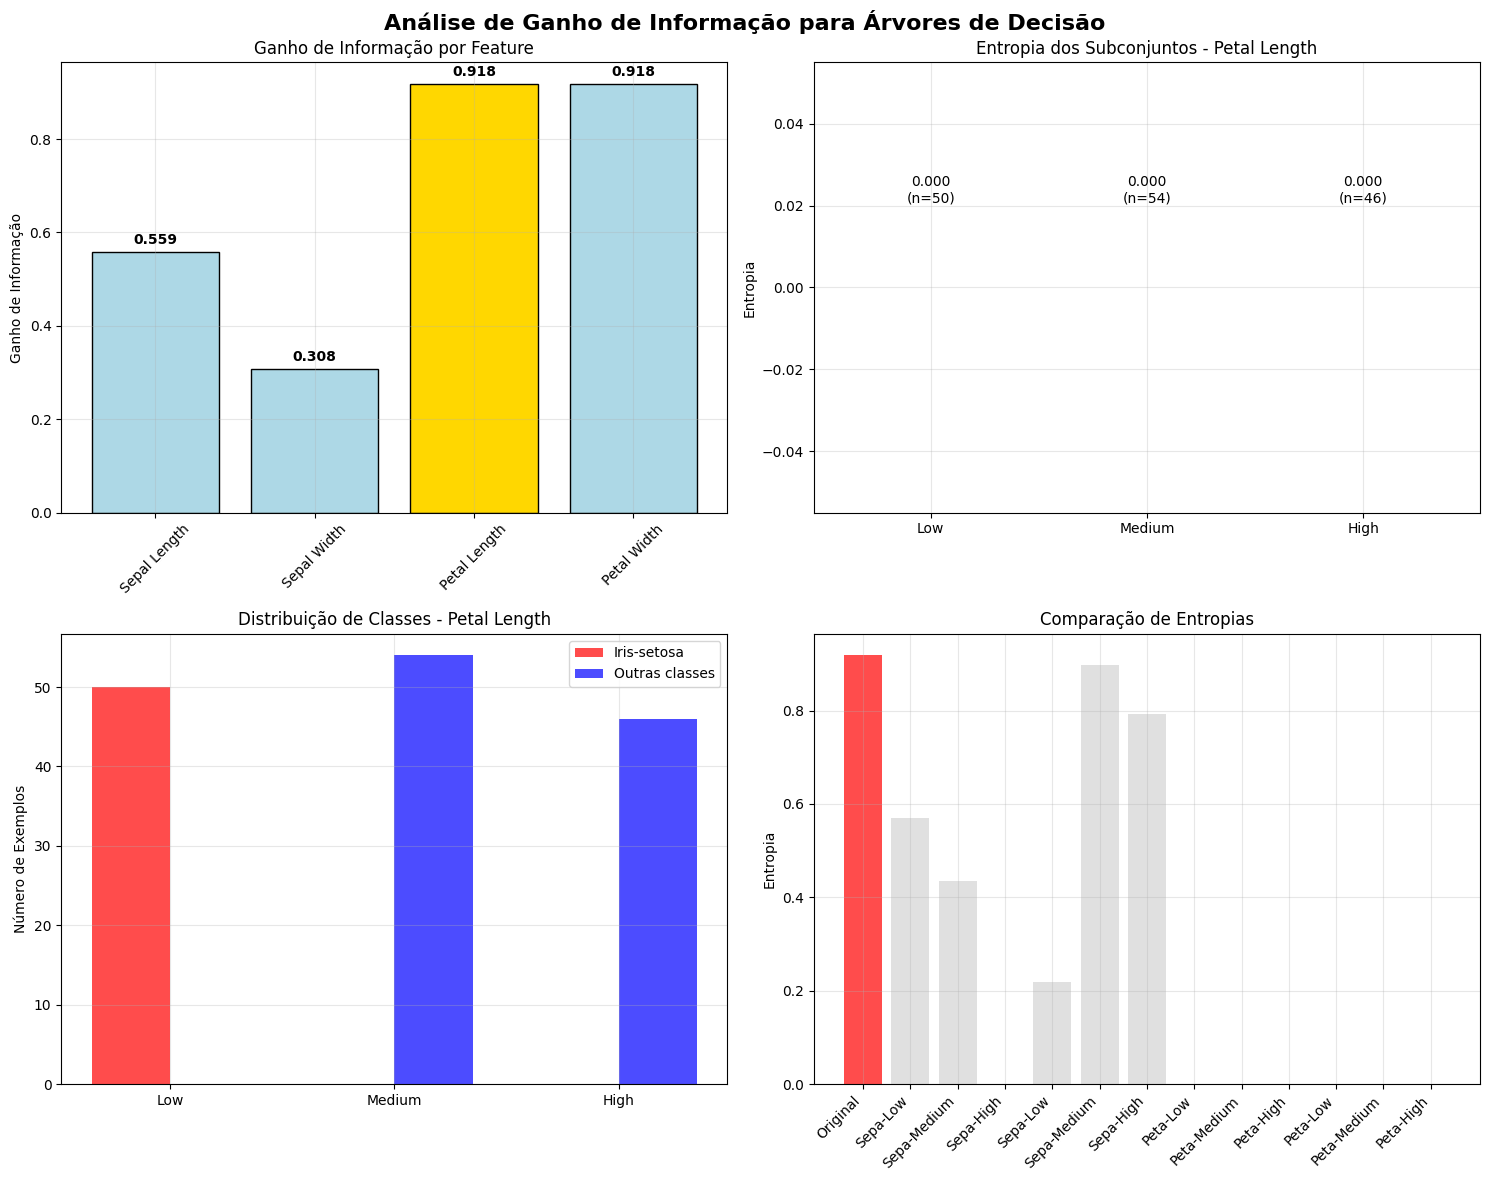


=== INTERPRETAÇÃO DOS RESULTADOS ===

**CAPACIDADE DISCRIMINATIVA**:

1. **Antes da partição** (conjunto S):
   - Entropia = 0.9183
   - Indica impureza moderada (mistura de classes)

2. **Após partição por Petal Length**:
   - Ganho = 0.9183
   - Redução significativa na entropia média
   - Melhora na capacidade de classificação

**O QUE ISSO SIGNIFICA**:
- Petal Length é a feature mais informativa para distinguir Iris-setosa
- Conhecer o valor de Petal Length reduz significativamente a incerteza
- Esta seria a melhor escolha para o nó raiz de uma árvore de decisão

**RANKING DE IMPORTÂNCIA**:
  1º. Petal Length: 0.9183 (Excelente)
  2º. Petal Width: 0.9183 (Excelente)
  3º. Sepal Length: 0.5587 (Excelente)
  4º. Sepal Width: 0.3081 (Boa)

**POTENCIAL DE CLASSIFICAÇÃO**:
- Redução da entropia: 60.8%
- Melhoria na pureza dos subconjuntos
- Base sólida para construção de árvore de decisão


In [5]:
# Análise detalhada: partição pela primeira feature (Sepal Length)
print(f"\n=== EXEMPLO DETALHADO: PARTIÇÃO POR {feature_names[0].upper()} ===")

feature_idx = 0  # Sepal Length
gain, subsets_info = calculate_information_gain(X_discretized, y_binary, feature_idx)

print(f"Analisando partição por {feature_names[feature_idx]}:")

# Mostrar limiares de discretização
low_thresh, high_thresh = thresholds[feature_idx]
print(f"Limiares de discretização:")
print(f"  Low: ≤ {low_thresh:.2f}")
print(f"  Medium: {low_thresh:.2f} < valor ≤ {high_thresh:.2f}")
print(f"  High: > {high_thresh:.2f}")

print(f"\nSubconjuntos criados:")
value_names = ['Low', 'Medium', 'High']

for value in [0, 1, 2]:  # low, medium, high
    if value in subsets_info:
        info = subsets_info[value]
        print(f"\n{value_names[value]} Dataset:")
        print(f"  Tamanho: {info['size']} exemplos ({info['weight']*100:.1f}% do total)")
        print(f"  Iris-setosa: {info['n_positive']} exemplos")
        print(f"  Outras: {info['n_negative']} exemplos")
        print(f"  Proporção Iris-setosa: {info['proportion_positive']:.3f}")
        print(f"  Entropia: {info['entropy']:.4f}")

# Calcular entropia ponderada
weighted_entropy = sum(info['weight'] * info['entropy'] for info in subsets_info.values())
print(f"\nEntropia ponderada dos subconjuntos:")
print(f"  Σ (|Sv|/|S|) × entropy(Sv) = {weighted_entropy:.4f}")

print(f"\nGanho de informação:")
print(f"  gain(S, {feature_names[feature_idx]}) = {original_entropy:.4f} - {weighted_entropy:.4f} = {gain:.4f}")

print(f"\n=== ANÁLISE COMPLETA: TODAS AS FEATURES ===")

# Calcular ganho para todas as features
gains_info = {}

for feature_idx in range(len(feature_names)):
    gain, subsets_info = calculate_information_gain(X_discretized, y_binary, feature_idx)
    gains_info[feature_idx] = {
        'gain': gain,
        'subsets': subsets_info,
        'feature_name': feature_names[feature_idx]
    }

# Mostrar resultados ordenados por ganho
print("Ganho de informação por feature:")
print(f"{'Feature':<15} {'Ganho':<8} {'Ranking'}")
print("-" * 35)

# Ordenar por ganho (maior primeiro)
sorted_features = sorted(gains_info.items(), key=lambda x: x[1]['gain'], reverse=True)

for rank, (feature_idx, info) in enumerate(sorted_features, 1):
    feature_name = info['feature_name']
    gain = info['gain']
    print(f"{feature_name:<15} {gain:<8.4f} {rank}")

# Feature com maior ganho
best_feature_idx, best_info = sorted_features[0]
best_feature_name = best_info['feature_name']
best_gain = best_info['gain']

print(f"\n**MELHOR FEATURE**: {best_feature_name} (ganho = {best_gain:.4f})")

# Análise detalhada da melhor feature
print(f"\n=== ANÁLISE DETALHADA: {best_feature_name.upper()} ===")

best_subsets = best_info['subsets']
print(f"Particionamento por {best_feature_name}:")

for value in [0, 1, 2]:
    if value in best_subsets:
        info = best_subsets[value]
        purity = max(info['proportion_positive'], 1 - info['proportion_positive'])
        purity_desc = "Muito puro" if purity > 0.9 else "Puro" if purity > 0.7 else "Impuro"
        
        print(f"\n{value_names[value]}:")
        print(f"  Tamanho: {info['size']} exemplos")
        print(f"  Entropia: {info['entropy']:.4f}")
        print(f"  Pureza: {purity:.3f} ({purity_desc})")
        
        if info['n_positive'] == info['size']:
            print(f"  → Todos são Iris-setosa!")
        elif info['n_negative'] == info['size']:
            print(f"  → Nenhum é Iris-setosa!")
        else:
            print(f"  → Misto: {info['n_positive']} Iris-setosa, {info['n_negative']} outras")

# Visualização dos ganhos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise de Ganho de Informação para Árvores de Decisão', fontsize=16, fontweight='bold')

# Gráfico 1: Ganho por feature
ax1 = axes[0, 0]
features = [gains_info[i]['feature_name'] for i in range(4)]
gains = [gains_info[i]['gain'] for i in range(4)]
colors = ['gold' if i == best_feature_idx else 'lightblue' for i in range(4)]

bars = ax1.bar(features, gains, color=colors, edgecolor='black')
ax1.set_title('Ganho de Informação por Feature')
ax1.set_ylabel('Ganho de Informação')
ax1.set_xticklabels(features, rotation=45)
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, gain in zip(bars, gains):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{gain:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Entropia dos subconjuntos da melhor feature
ax2 = axes[0, 1]
subset_names = [f'{value_names[v]}' for v in [0, 1, 2] if v in best_subsets]
subset_entropies = [best_subsets[v]['entropy'] for v in [0, 1, 2] if v in best_subsets]
subset_sizes = [best_subsets[v]['size'] for v in [0, 1, 2] if v in best_subsets]

bars2 = ax2.bar(subset_names, subset_entropies, color=['lightcoral', 'lightgreen', 'lightyellow'])
ax2.set_title(f'Entropia dos Subconjuntos - {best_feature_name}')
ax2.set_ylabel('Entropia')
ax2.grid(True, alpha=0.3)

# Adicionar tamanhos dos subconjuntos
for bar, entropy, size in zip(bars2, subset_entropies, subset_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{entropy:.3f}\n(n={size})', ha='center', va='bottom')

# Gráfico 3: Distribuição de classes na melhor feature
ax3 = axes[1, 0]
x_pos = np.arange(len(subset_names))
positives = [best_subsets[v]['n_positive'] for v in [0, 1, 2] if v in best_subsets]
negatives = [best_subsets[v]['n_negative'] for v in [0, 1, 2] if v in best_subsets]

width = 0.35
bars3a = ax3.bar(x_pos - width/2, positives, width, label='Iris-setosa', color='red', alpha=0.7)
bars3b = ax3.bar(x_pos + width/2, negatives, width, label='Outras classes', color='blue', alpha=0.7)

ax3.set_title(f'Distribuição de Classes - {best_feature_name}')
ax3.set_ylabel('Número de Exemplos')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(subset_names)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Comparação visual das entropias
ax4 = axes[1, 1]
all_entropies = [original_entropy] + [gains_info[i]['subsets'][v]['entropy'] 
                                     for i in range(4) for v in [0, 1, 2] 
                                     if v in gains_info[i]['subsets']]
labels = ['Original'] + [f'{gains_info[i]["feature_name"][:4]}-{value_names[v]}' 
                        for i in range(4) for v in [0, 1, 2] 
                        if v in gains_info[i]['subsets']]

# Destacar conjunto original e subconjuntos da melhor feature
colors_entropy = ['red'] + ['gold' if label.startswith(best_feature_name[:4]) else 'lightgray' 
                           for label in labels[1:]]

bars4 = ax4.bar(range(len(all_entropies)), all_entropies, color=colors_entropy, alpha=0.7)
ax4.set_title('Comparação de Entropias')
ax4.set_ylabel('Entropia')
ax4.set_xticks(range(len(labels)))
ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== INTERPRETAÇÃO DOS RESULTADOS ===")

print(f"""
**CAPACIDADE DISCRIMINATIVA**:

1. **Antes da partição** (conjunto S):
   - Entropia = {original_entropy:.4f}
   - Indica impureza moderada (mistura de classes)

2. **Após partição por {best_feature_name}**:
   - Ganho = {best_gain:.4f}
   - Redução significativa na entropia média
   - Melhora na capacidade de classificação

**O QUE ISSO SIGNIFICA**:
- {best_feature_name} é a feature mais informativa para distinguir Iris-setosa
- Conhecer o valor de {best_feature_name} reduz significativamente a incerteza
- Esta seria a melhor escolha para o nó raiz de uma árvore de decisão

**RANKING DE IMPORTÂNCIA**:""")

for rank, (feature_idx, info) in enumerate(sorted_features, 1):
    effectiveness = "Excelente" if info['gain'] > 0.5 else "Boa" if info['gain'] > 0.3 else "Moderada" if info['gain'] > 0.1 else "Fraca"
    print(f"  {rank}º. {info['feature_name']}: {info['gain']:.4f} ({effectiveness})")

print(f"\n**POTENCIAL DE CLASSIFICAÇÃO**:")
improvement = (1 - weighted_entropy / original_entropy) * 100
print(f"- Redução da entropia: {improvement:.1f}%")
print(f"- Melhoria na pureza dos subconjuntos")
print(f"- Base sólida para construção de árvore de decisão")


In [6]:
# Construção de árvores de decisão usando esta estratégia
print(f"\n=== COMO CONSTRUIR UMA ÁRVORE DE DECISÃO ===")

def build_decision_tree_explanation():
    """Explica o algoritmo de construção de árvores de decisão"""
    
    print("""
**ALGORITMO ID3 (Iterative Dichotomiser 3)**:

1. **Nó Raiz**:
   - Começar com o conjunto completo S
   - Calcular entropia de S
   - Se entropia = 0 → nó folha (classe pura)
   - Senão → continuar particionamento

2. **Seleção da Feature**:
   - Calcular ganho de informação para todas as features
   - Escolher a feature com MAIOR ganho
   - Esta torna-se o critério de divisão do nó

3. **Particionamento**:
   - Dividir o conjunto pelos valores da feature escolhida
   - Criar um ramo para cada valor (Low, Medium, High)
   - Cada ramo recebe o subconjunto correspondente

4. **Recursão**:
   - Para cada subconjunto criado:
     * Se puro (entropia = 0) → criar nó folha
     * Se impuro → repetir processo (voltar ao passo 1)
     * Se não há mais features → classe majoritária

5. **Critérios de Parada**:
   - Entropia = 0 (conjunto puro)
   - Não há mais features para dividir
   - Número mínimo de exemplos atingido
   - Profundidade máxima alcançada
""")

build_decision_tree_explanation()

# Demonstração prática: construção da primeira camada
print(f"=== DEMONSTRAÇÃO: PRIMEIRA CAMADA DA ÁRVORE ===")

print(f"""
**PASSO A PASSO PARA NOSSO CASO**:

1. **Nó Raiz**:
   - Dataset completo: 150 exemplos
   - Entropia inicial: {original_entropy:.4f}
   - Objetivo: classificar Iris-setosa vs. outras

2. **Escolha da Feature**:
   - Testamos todas as 4 features
   - {best_feature_name} tem maior ganho: {best_gain:.4f}
   - DECISÃO: usar {best_feature_name} como nó raiz

3. **Criação dos Ramos**:""")

# Mostrar a estrutura da primeira camada
for value in [0, 1, 2]:
    if value in best_subsets:
        info = best_subsets[value]
        value_name = value_names[value]
        
        if info['entropy'] == 0:
            if info['n_positive'] == info['size']:
                decision = "→ FOLHA: Iris-setosa"
            else:
                decision = "→ FOLHA: Outras classes"
        else:
            decision = f"→ CONTINUAR (entropia={info['entropy']:.4f})"
        
        print(f"   {best_feature_name} = {value_name}: {info['size']} exemplos {decision}")

# Visualizar a árvore textualmente
print(f"\n=== REPRESENTAÇÃO DA ÁRVORE (PRIMEIRA CAMADA) ===")

print(f"""
                    [RAIZ]
               {best_feature_name} = ?
               Entropia: {original_entropy:.4f}
                 /      |      \\
                /       |       \\
            Low        Medium     High
       ({best_subsets[0]['size']} exemplos)   ({best_subsets[1]['size']} exemplos)    ({best_subsets[2]['size']} exemplos)
     Ent: {best_subsets[0]['entropy']:.3f}    Ent: {best_subsets[1]['entropy']:.3f}     Ent: {best_subsets[2]['entropy']:.3f}
""")

# Análise dos próximos passos
print(f"**PRÓXIMOS PASSOS**:")

for value in [0, 1, 2]:
    if value in best_subsets:
        info = best_subsets[value]
        value_name = value_names[value]
        
        if info['entropy'] == 0:
            print(f"• Ramo {value_name}: PARAR (pureza alcançada)")
        else:
            print(f"• Ramo {value_name}: CONTINUAR particionamento")
            print(f"  - Calcular ganho das features restantes")
            print(f"  - Escolher melhor feature para subdividir")
            print(f"  - Criar novos subnós")

# Vantagens e limitações
print(f"\n=== VANTAGENS E LIMITAÇÕES ===")

print(f"""
**VANTAGENS DO MÉTODO**:
• Interpretabilidade: regras claras e legíveis
• Não assume distribuição específica dos dados
• Lida bem com features categóricas
• Identifica automaticamente features importantes
• Robusto a outliers

**LIMITAÇÕES**:
• Tendência ao overfitting (árvores muito profundas)
• Instabilidade (pequenas mudanças → árvores diferentes)
• Bias para features com mais valores
• Dificuldade com relações lineares complexas
• Pode criar árvores desbalanceadas

**MELHORIAS POSSÍVEIS**:
• Poda da árvore (pruning)
• Critérios alternativos (Gini, gain ratio)
• Ensemble methods (Random Forest)
• Regularização (profundidade máxima, min samples)
""")

# Comparação com outros métodos
print(f"\n=== COMPARAÇÃO COM OUTROS ALGORITMOS ===")

print(f"""
**ÁRVORES DE DECISÃO vs. ALGORITMOS ANTERIORES**:

| Aspecto              | Árvore Decisão | k-NN      | Naive Bayes |
|---------------------|----------------|-----------|-------------|
| Interpretabilidade   | Excelente      | Fraca     | Boa         |
| Velocidade (predição)| Muito rápida   | Lenta     | Rápida      |
| Dados categóricos   | Nativa         | Problemas | Boa         |
| Overfitting         | Alto risco     | Médio     | Baixo       |
| Preparação dados    | Mínima         | Escala    | Discretização|

**QUANDO USAR ÁRVORES**:
• Quando interpretabilidade é crucial
• Dados com mix de tipos (numérico + categórico)  
• Necessidade de regras explicitas
• Base para algoritmos ensemble
""")

# Exemplo de regras extraídas
print(f"\n=== REGRAS EXTRAÍDAS DA ANÁLISE ===")

print("Regras para classificar Iris-setosa:")

for value in [0, 1, 2]:
    if value in best_subsets:
        info = best_subsets[value]
        value_name = value_names[value]
        
        low_thresh, high_thresh = thresholds[best_feature_idx]
        
        if value == 0:  # Low
            condition = f"{best_feature_name} ≤ {low_thresh:.2f}"
        elif value == 1:  # Medium  
            condition = f"{low_thresh:.2f} < {best_feature_name} ≤ {high_thresh:.2f}"
        else:  # High
            condition = f"{best_feature_name} > {high_thresh:.2f}"
        
        probability = info['proportion_positive']
        
        if probability >= 0.9:
            prediction = "Iris-setosa"
            confidence = "Alta"
        elif probability >= 0.5:
            prediction = "Provavelmente Iris-setosa"
            confidence = "Média"
        elif probability >= 0.1:
            prediction = "Possivelmente outras classes"
            confidence = "Média"
        else:
            prediction = "Outras classes"
            confidence = "Alta"
        
        print(f"• SE {condition}")
        print(f"  ENTÃO {prediction} (confiança: {confidence})")
        print(f"  Base: {info['size']} exemplos, {probability:.1%} Iris-setosa")
        print()

print("Essas regras capturam o conhecimento extraído dos dados de forma interpretável!")



=== COMO CONSTRUIR UMA ÁRVORE DE DECISÃO ===

**ALGORITMO ID3 (Iterative Dichotomiser 3)**:

1. **Nó Raiz**:
   - Começar com o conjunto completo S
   - Calcular entropia de S
   - Se entropia = 0 → nó folha (classe pura)
   - Senão → continuar particionamento

2. **Seleção da Feature**:
   - Calcular ganho de informação para todas as features
   - Escolher a feature com MAIOR ganho
   - Esta torna-se o critério de divisão do nó

3. **Particionamento**:
   - Dividir o conjunto pelos valores da feature escolhida
   - Criar um ramo para cada valor (Low, Medium, High)
   - Cada ramo recebe o subconjunto correspondente

4. **Recursão**:
   - Para cada subconjunto criado:
     * Se puro (entropia = 0) → criar nó folha
     * Se impuro → repetir processo (voltar ao passo 1)
     * Se não há mais features → classe majoritária

5. **Critérios de Parada**:
   - Entropia = 0 (conjunto puro)
   - Não há mais features para dividir
   - Número mínimo de exemplos atingido
   - Profundidade máxima a